In [1]:
import numpy as np
import scipy, scipy.spatial
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa, librosa.display
import speechpy
from pydub import AudioSegment
from matplotlib.patches import ConnectionPatch
%matplotlib inline

import io
from urllib.request import urlopen

In [2]:
plt.style.use('seaborn-muted')
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.bottom'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = None

/var/folders/l7/8569zcwj6sv65s8tl26x84kh0000gn/T/ipykernel_94704/1168612819.py:11: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  plt.rcParams['image.interpolation'] = None


In [20]:
def onsetDetect(signal, sr, hop_length, n_fft):
    onset_frames = librosa.onset.onset_detect(signal, sr=sr, hop_length=hop_length)
    onset_frames_back = librosa.onset.onset_detect(signal, sr=sr, hop_length=hop_length, backtrack=True)
    onset_times = librosa.frames_to_time(onset_frames, sr=sr, hop_length=hop_length, n_fft=n_fft)
    trim_frames = []
    trim_frames.append(onset_frames_back[0]-1)
    trim_frames.append(onset_frames[-1]+2)
    trim_times = librosa.frames_to_time(trim_frames, sr=sr, hop_length=hop_length, n_fft = n_fft)
    return trim_frames, trim_times

def drawOnset(signal, trim_times, sr):
    librosa.display.waveshow(signal, sr=sr)
    plt.vlines(trim_times, min(signal), max(signal), color='r', alpha=0.8)
    
def trimSound(path, filename, trim_times):
    sound = AudioSegment.from_file(path+filename, format='mp3')
    trim = sound[trim_times[0]*1000:trim_times[1]*1000]
    return trim

def trimSave(trim, path, filename):
    trim.export(path + filename, format='mp3')
    
def getMFCC(signal, n_mfcc, sr, hop_length, n_fft):
    mfccs = librosa.feature.mfcc(signal, sr=sr, hop_length=hop_length, n_mfcc=n_mfcc, n_fft=n_fft)
    mfccs = mfccs[1:,]
    delta_mfccs = librosa.feature.delta(mfccs)
    delta2_mfccs = librosa.feature.delta(mfccs, order=2)
    comprehensive_mfccs = np.concatenate((mfccs, delta_mfccs, delta2_mfccs))
    return comprehensive_mfccs

def showMFCC(mfcc, sr, hop_length, n_fft):
    librosa.display.specshow(mfcc,
                        x_axis="time",
                        sr = sr,
                        hop_length = hop_length,
                        n_fft = n_fft)
    plt.colorbar(format="%+2.f")
    plt.show()
    
def amplitude_envelope(signal, n_fft, hop_length):
    return np.array([max(signal[i:i+n_fft]) for i in range(0, len(signal), hop_length)])


def pad(ae, target_len):
    return np.pad(ae, (0, target_len-ae.size))

def getMFCCNorm(mfcc):
    norm = speechpy.processing.cmvn(mfcc.T, variance_normalization=True)
    return norm.T

def DTW(ref_mfcc, comp_mfcc):
    D, wp = librosa.sequence.dtw(X=ref_mfcc, Y=comp_mfcc, metric='euclidean', backtrack=True)
    wp_s = np.asarray(wp) * hop_length / sr
    return D, wp, wp_s

def plotDTW(D, wp_s):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    librosa.display.specshow(D, x_axis='time', y_axis='time',
                             cmap='gray_r', hop_length=hop_length)
    ax.plot(wp_s[:, 1], wp_s[:, 0], marker='o', color='r')
    plt.title('Warping Path on Acc. Cost Matrix $D$')
    plt.colorbar()
    
def plotAlign(sig1, sig2):
    fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(12, 8))

    # Plot x_2
    librosa.display.waveshow(sig2, sr=sr, ax=ax2)
    ax2.set(title='comparison')

    # Plot x_1
    librosa.display.waveshow(sig1, sr=sr, ax=ax1)
    ax1.set(title='reference')
    ax1.label_outer()

    n_arrows = 20
    for tp1, tp2 in wp_s[::len(wp_s)//n_arrows]:
        # Create a connection patch between the aligned time points
        # in each subplot
        con = ConnectionPatch(xyA=(tp1, 0), xyB=(tp2, 0),
                              axesA=ax1, axesB=ax2,
                              coordsA='data', coordsB='data',
                              color='r', linestyle='--',
                              alpha=0.5)
        ax2.add_artist(con)
        
def getDiff(ref_mfcc, comp_mfcc, wp):
    x = np.linspace(0, ref_mfcc.shape[1]-1, ref_mfcc.shape[1])
    re_wp = wp[::-1]
    y = [0] * ref_mfcc.shape[1]
    sig1 = 0
    for a, b in re_wp:
        val = max(0, (sum(np.abs(ref_mfcc[:,a]))-sum(np.abs(comp_mfcc[:,b])))/sum(np.abs(ref_mfcc[:,a])))
        if sig1 == a:
            y[a] = min(y[a],val)
        else:
            y[a] = min(1, val)
            sig1 = a
    return x, y, re_wp

def plotAll(x,y,ref_ae,comp_ae):
    if comp_ae.size < x.size:
        comp_ae = pad(comp_ae, x.size)
    plt.figure(figsize=(13,5))
    plt.plot(x,y, label="MFCC_Diff", color="r", linestyle='--')
    plt.plot(x,ref_ae, label="ref", color = 'darkblue', )
    plt.plot(x,comp_ae, label="comp", color = 'skyblue',)
    plt.xlabel("frames")
    plt.legend()

/Users/spin/opt/anaconda3/envs/ZB_pytorch3.9/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
/Users/spin/opt/anaconda3/envs/ZB_pytorch3.9/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


220 551


/var/folders/l7/8569zcwj6sv65s8tl26x84kh0000gn/T/ipykernel_94704/740698650.py:24: FutureWarning: Pass y=[ 8.0074836e-10 -1.5618271e-09  2.6030769e-09 ... -1.0464340e-05
  1.1520796e-03  7.6141208e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal, sr=sr, hop_length=hop_length, n_mfcc=n_mfcc, n_fft=n_fft)
/var/folders/l7/8569zcwj6sv65s8tl26x84kh0000gn/T/ipykernel_94704/740698650.py:24: FutureWarning: Pass y=[-2.7378555e-06 -9.5968368e-05 -6.5968605e-05 ...  1.0318346e-03
  1.5422702e-06  1.2114234e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal, sr=sr, hop_length=hop_length, n_mfcc=n_mfcc, n_fft=n_fft)


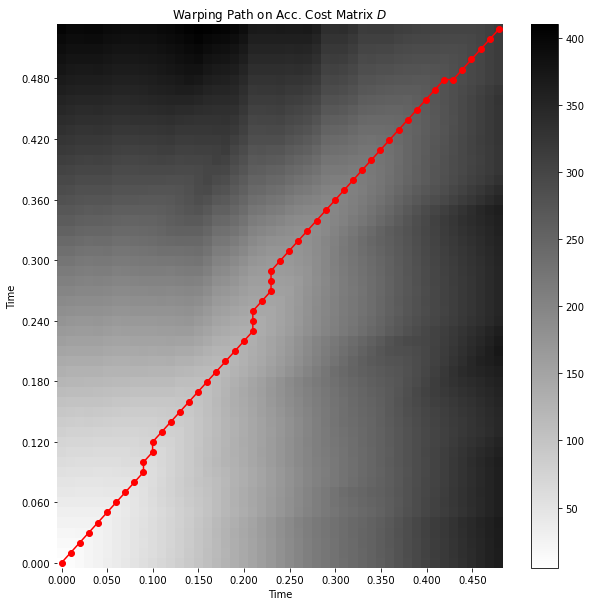

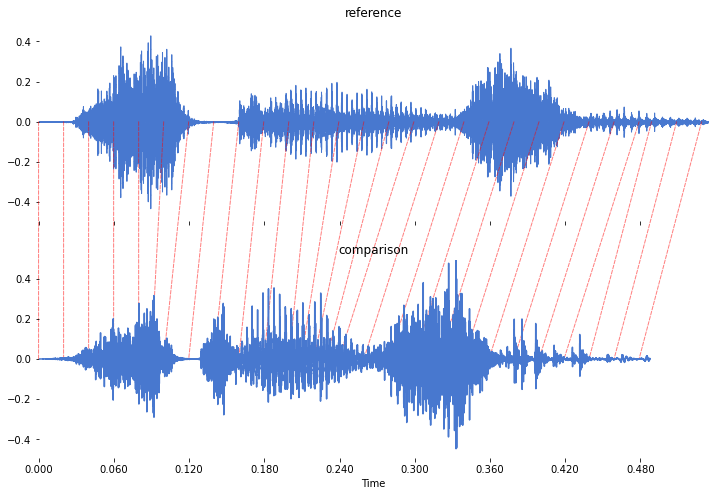

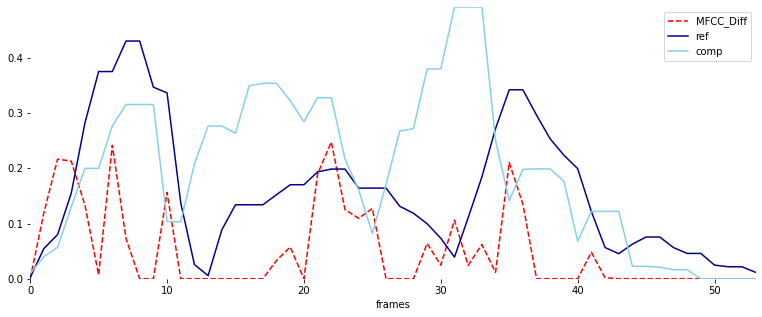

In [21]:
t1 = './data/naver_w.mp3'
t2 = './data/oxford_w.mp3'

y_t1, sr = librosa.load(t1)
y_t2, _ = librosa.load(t2)

hop_length = int(0.01 * sr)
n_fft = int(0.025 * sr)
print(hop_length, n_fft)

y_t1 = librosa.effects.preemphasis(y_t1)
y_t2 = librosa.effects.preemphasis(y_t2)

y_t1_trim, _ = librosa.effects.trim(y_t1, top_db = 25)
y_t2_trim, _ = librosa.effects.trim(y_t2, top_db = 25)

t1_mfcc = getMFCC(y_t1_trim, sr=sr, hop_length=hop_length, n_fft=n_fft, n_mfcc=13)
t2_mfcc = getMFCC(y_t2_trim, sr=sr, hop_length=hop_length, n_fft=n_fft, n_mfcc=13)

t1_mfcc_norm = getMFCCNorm(t1_mfcc)
t2_mfcc_norm = getMFCCNorm(t2_mfcc)

t1_ae = amplitude_envelope(y_t1_trim, n_fft, hop_length)
t2_ae = amplitude_envelope(y_t2_trim, n_fft, hop_length)

D, wp, wp_s = DTW(t1_mfcc_norm, t2_mfcc_norm)
plotDTW(D, wp_s)
plotAlign(y_t1_trim, y_t2_trim)

x, y, re_wp = getDiff(t1_mfcc_norm, t2_mfcc_norm, wp)
plotAll(x,y,t1_ae,t2_ae)

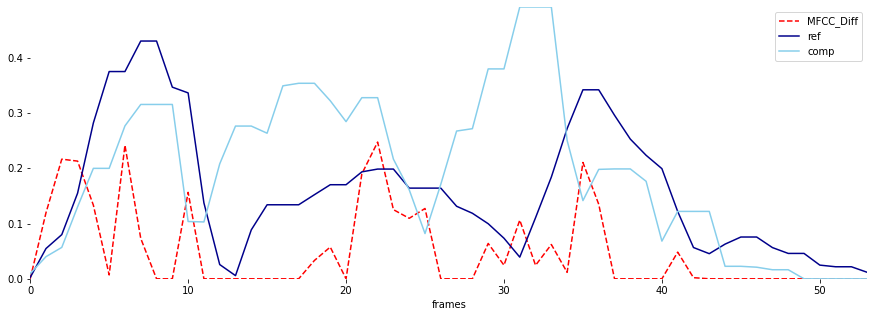

In [18]:
x, y, re_wp = getDiff(t1_mfcc_norm, t2_mfcc_norm, wp)
plotAll(x,y,t1_ae,t2_ae)

In [14]:
def sound_diff(ref, target):
   
    def onsetDetect(signal, sr, hop_length, n_fft):
        onset_frames = librosa.onset.onset_detect(signal, sr=sr, hop_length=hop_length)
        onset_frames_back = librosa.onset.onset_detect(signal, sr=sr, hop_length=hop_length, backtrack=True)
        onset_times = librosa.frames_to_time(onset_frames, sr=sr, hop_length=hop_length, n_fft=n_fft)
        trim_frames = []
        trim_frames.append(onset_frames_back[0]-1)
        trim_frames.append(onset_frames[-1]+2)
        trim_times = librosa.frames_to_time(trim_frames, sr=sr, hop_length=hop_length, n_fft = n_fft)
        return trim_frames, trim_times

    def drawOnset(signal, trim_times, sr):
        librosa.display.waveshow(signal, sr=sr)
        plt.vlines(trim_times, min(signal), max(signal), color='r', alpha=0.8)
        
    def trimSound(path, filename, trim_times):
        sound = AudioSegment.from_file(path+filename, format='mp3')
        trim = sound[trim_times[0]*1000:trim_times[1]*1000]
        return trim

    def trimSave(trim, path, filename):
        trim.export(path + filename, format='mp3')
        
    def getMFCC(signal, n_mfcc, sr, hop_length, n_fft):
        mfccs = librosa.feature.mfcc(y=signal, sr=sr, hop_length=hop_length, n_mfcc=n_mfcc, n_fft=n_fft)
        mfccs = mfccs[1:,]
        delta_mfccs = librosa.feature.delta(mfccs)
        delta2_mfccs = librosa.feature.delta(mfccs, order=2)
        comprehensive_mfccs = np.concatenate((mfccs, delta_mfccs, delta2_mfccs))
        return comprehensive_mfccs

    def showMFCC(mfcc, sr, hop_length, n_fft):
        librosa.display.specshow(mfcc,
                            x_axis="time",
                            sr = sr,
                            hop_length = hop_length,
                            n_fft = n_fft)
        plt.colorbar(format="%+2.f")
        plt.show()
        
    def amplitude_envelope(signal, n_fft, hop_length):
        return np.array([max(signal[i:i+n_fft]) for i in range(0, len(signal), hop_length)])


    def pad(ae, target_len):
        return np.pad(ae, (0, target_len-ae.size))

    def getMFCCNorm(mfcc):
        norm = speechpy.processing.cmvn(mfcc.T, variance_normalization=True)
        return norm.T

    def DTW(ref_mfcc, comp_mfcc):
        D, wp = librosa.sequence.dtw(X=ref_mfcc, Y=comp_mfcc, metric='euclidean', backtrack=True)
        wp_s = np.asarray(wp) * hop_length / sr
        return D, wp, wp_s

    def plotDTW(D, wp_s):
        fig = plt.figure(figsize=(13, 10))
        ax = fig.add_subplot(111)
        librosa.display.specshow(D, x_axis='time', y_axis='time',
                                cmap='gray_r', hop_length=hop_length)
        ax.plot(wp_s[:, 1], wp_s[:, 0], marker='o', color='r')
        plt.rcParams['axes.grid'] = False
        plt.title('Warping Path on Acc. Cost Matrix $D$')
        plt.colorbar()
        
    def plotAlign(sig1, sig2):
        fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(13, 10))

        # Plot x_2
        librosa.display.waveshow(sig2, sr=sr, ax=ax2)
        ax2.set(title='comparison')

        # Plot x_1
        librosa.display.waveshow(sig1, sr=sr, ax=ax1)
        ax1.set(title='reference')
        ax1.label_outer()

        n_arrows = 20
        for tp1, tp2 in wp_s[::len(wp_s)//n_arrows]:
            # Create a connection patch between the aligned time points
            # in each subplot
            con = ConnectionPatch(xyA=(tp1, 0), xyB=(tp2, 0),
                                axesA=ax1, axesB=ax2,
                                coordsA='data', coordsB='data',
                                color='r', linestyle='--',
                                alpha=0.5)
            ax2.add_artist(con)
            
    def getDiff(ref_mfcc, comp_mfcc, wp):
        x = np.linspace(0, ref_mfcc.shape[1]-1, ref_mfcc.shape[1])
        re_wp = wp[::-1]
        y = [0] * ref_mfcc.shape[1]
        sig1 = 0
        for a, b in re_wp:
            val = max(0, (sum(np.abs(ref_mfcc[:,a]))-sum(np.abs(comp_mfcc[:,b])))/sum(np.abs(ref_mfcc[:,a])))
            if sig1 == a:
                y[a] = min(y[a],val)
            else:
                y[a] = min(1, val)
                sig1 = a
        return x, y

    def plotAll(x,y,ref_ae,comp_ae):
        if comp_ae.size < x.size:
            comp_ae = pad(comp_ae, x.size)
        plt.plot(x,y, label="MFCC_Diff", color="r", linestyle='--')
        plt.plot(x,ref_ae, label="ref", color = 'darkblue', )
        plt.plot(x,comp_ae, label="comp", color = 'skyblue',)
        plt.xlabel("frames")
        plt.legend()
        
    t1 = ref
    t2 = target

    y_t1, sr = librosa.load(t1, mono=True)
    y_t2, _ = librosa.load(t2, mono=True)

    hop_length = int(0.01 * sr)
    n_fft = int(0.025 * sr)
    print(hop_length, n_fft)

    y_t1 = librosa.effects.preemphasis(y_t1)
    y_t2 = librosa.effects.preemphasis(y_t2)

    y_t1_trim, _ = librosa.effects.trim(y_t1, top_db = 25)
    y_t2_trim, _ = librosa.effects.trim(y_t2, top_db = 25)

    t1_mfcc = getMFCC(y_t1_trim, sr=sr, hop_length=hop_length, n_fft=n_fft, n_mfcc=13)
    t2_mfcc = getMFCC(y_t2_trim, sr=sr, hop_length=hop_length, n_fft=n_fft, n_mfcc=13)

    t1_mfcc_norm = getMFCCNorm(t1_mfcc)
    t2_mfcc_norm = getMFCCNorm(t2_mfcc)

    t1_ae = amplitude_envelope(y_t1_trim, n_fft, hop_length)
    t2_ae = amplitude_envelope(y_t2_trim, n_fft, hop_length)

    D, wp, wp_s = DTW(t1_mfcc_norm, t2_mfcc_norm)
    x, y = getDiff(t1_mfcc_norm, t2_mfcc_norm, wp)
    return plotDTW(D, wp_s), plotAlign(y_t1_trim, y_t2_trim), plotAll(x,y,t1_ae,t2_ae)


    

/Users/spin/opt/anaconda3/envs/ZB_pytorch3.9/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
/Users/spin/opt/anaconda3/envs/ZB_pytorch3.9/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


220 551


(None, None, None)

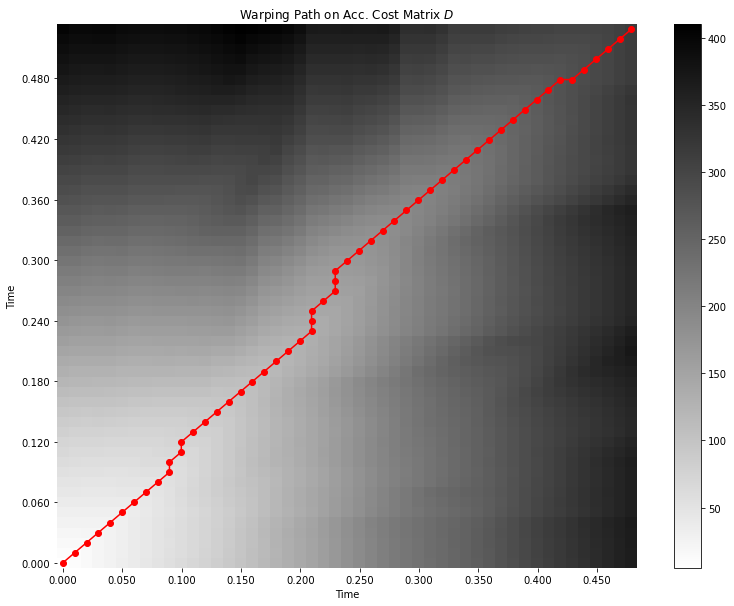

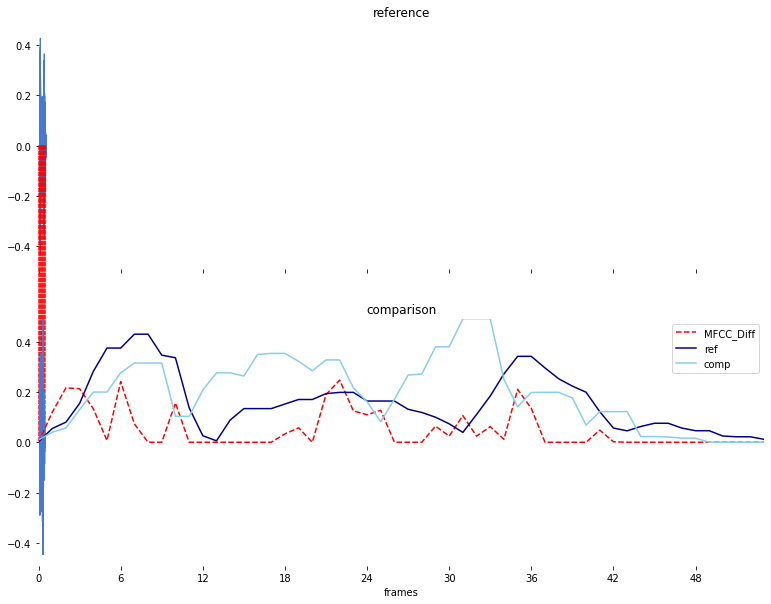

In [15]:
sound_diff(t1, t2)

In [11]:
x, y, re_wp = getDiff(t1_mfcc_norm, t2_mfcc_norm, wp)
plotAll(x,y,t1_ae,t2_ae)

NameError: name 't1_mfcc_norm' is not defined

In [2]:
from bs4 import BeautifulSoup
import requests
import urllib.request
import re
import pathlib
import os

cambridge = 'https://dictionary.cambridge.org'
dic = 'https://dictionary.cambridge.org/dictionary/english-korean/'
word = 'station'

r = requests.get(dic+word, headers={'User-Agent':'Mozilla/5.0'})
url = r.content
soup = BeautifulSoup(url, 'html.parser')

camb_sound_raw = soup.find_all('source')[2]
camb_sound_geturl = re.search('"(.+?)"', str(camb_sound_raw)).group(1)
camb_sound_ref_url = cambridge+camb_sound_geturl

file = requests.get(camb_sound_ref_url, headers=headers, allow_redirects=True)
path = os.getcwd()+'/data/'
if os.path.exists(path+word) == True:
    pass
else:
    mp3_path = os.makedirs(path+word)
mp3_path = path+word+'/ref.mp3'
open(mp3_path, 'wb').write(file.content)

SSLError: HTTPSConnectionPool(host='dictionary.cambridge.org', port=443): Max retries exceeded with url: /dictionary/english-korean/station (Caused by SSLError("Can't connect to HTTPS URL because the SSL module is not available."))

/Users/spin/opt/anaconda3/envs/ZB_pytorch3.9/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
/Users/spin/opt/anaconda3/envs/ZB_pytorch3.9/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


220 551


(None, None)

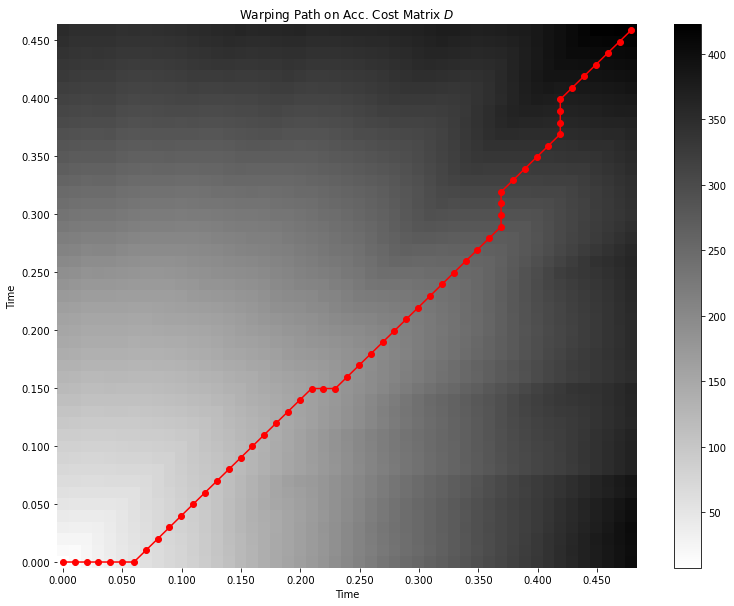

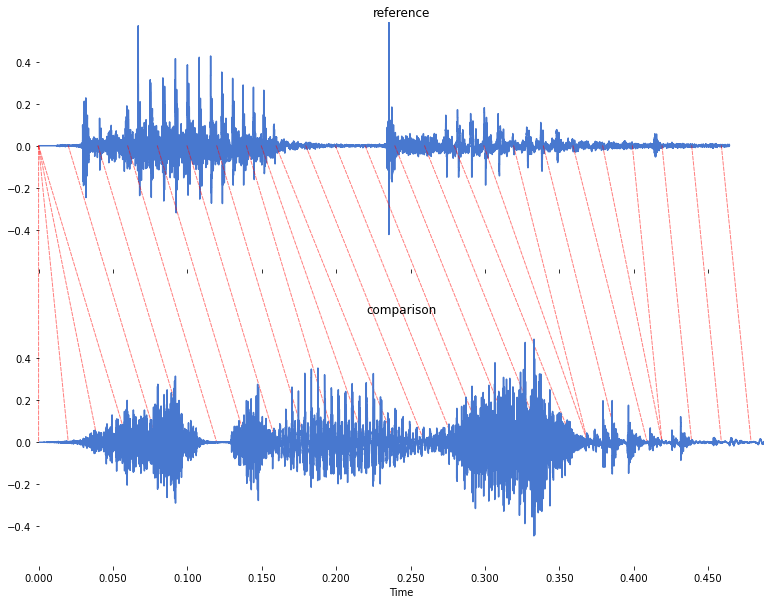

In [132]:
ref_sound = mp3_path
sound_diff(ref_sound, t2)

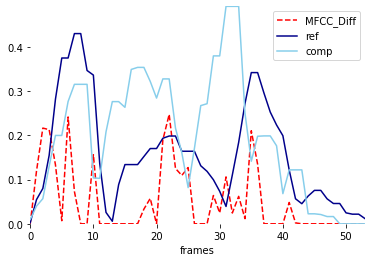